# Inidivudal ML Transfer Learning Assignment

**Name**: Clara Killeen

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 
from mpl_toolkits.axes_grid1 import ImageGrid
import math

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/Data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Data - Copy/archive/Train/5/00005_00053_00014.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00015.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00016.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00017.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00018.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00019.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00020.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00021.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00022.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00023.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00024.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00025.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00026.png  
 extracting: Data - Copy/archive/Train/5/00005_00053_00027.png  
 extracting: Data - Copy/archive/Train/

In [2]:
print(os.listdir('../content/Data - Copy/archive'))

['Test', 'Test.csv', 'Meta', 'Train', 'Meta.csv', 'Train.csv']


### The following is from the kaggle script accompanying this dataset

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
df1 = pd.read_csv('../Data/archive/Train.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 8 columns


In [ ]:
df1.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


### The following is for creating training + val set with no data generators:

In [3]:
train_dir = '../content/Data - Copy/archive/Train'

imageid_path_dict1 = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(train_dir,"*", '*.png'))}

#os.path.join(train_dir,"*", '*.png')

In [4]:
list_keys = [ k for k in imageid_path_dict1 ]

In [5]:
imageid_path_dict2 = {imageid_path_dict1[k]: k for k in list_keys}
imageid_path_dict = {imageid_path_dict2[k]:k for k in imageid_path_dict2}

In [8]:
class_dict = {}
for x in imageid_path_dict:
    f_1 = os.path.split(imageid_path_dict[x])
    f_2 = os.path.split(f_1[0])
    class_dict[imageid_path_dict[x]] = f_2[1]

In [9]:
def breakdown(lablist, classes2): #lablist is the labels as a list, classes2 is the final number 
    
    total = 0
    for typ in classes2:
       
        total += lablist.count(typ)


    for typ in classes2:
        print( typ ,":", lablist.count(typ), round(lablist.count(typ)/total, 3))
    print(total)   
    
def labels_quick_order(image_dir, class_dict, classes_final):
    c2 = classes_final
    op = []
    for x in sorted(image_dir):
        op.append(class_dict[image_dir[x]])
        
    labels = np.asarray(op)
    labelslist = (labels.tolist())
    
    labels_num = []
    for x in labelslist:
        for i in range(len(c2)):
            if x == c2[i]:
                labels_num.append(np.asarray([i]))
                
            
    
    labels_num = np.asarray(labels_num)
    print(labels_num.shape)
    return labels_num, labelslist

In [73]:
classes = list(range(43))
classes = [str(x) for x in classes]

In [11]:
labels_num, labels_list =labels_quick_order(imageid_path_dict , class_dict, classes)

(39209, 1)


In [12]:
breakdown(labels_list, classes)

0 : 210 0.005
1 : 2220 0.057
2 : 2250 0.057
3 : 1410 0.036
4 : 1980 0.05
5 : 1860 0.047
6 : 420 0.011
7 : 1440 0.037
8 : 1410 0.036
9 : 1470 0.037
10 : 2010 0.051
11 : 1320 0.034
12 : 2100 0.054
13 : 2160 0.055
14 : 780 0.02
15 : 630 0.016
16 : 420 0.011
17 : 1110 0.028
18 : 1200 0.031
19 : 210 0.005
20 : 360 0.009
21 : 330 0.008
22 : 390 0.01
23 : 510 0.013
24 : 270 0.007
25 : 1500 0.038
26 : 600 0.015
27 : 240 0.006
28 : 540 0.014
29 : 270 0.007
30 : 450 0.011
31 : 780 0.02
32 : 240 0.006
33 : 689 0.018
34 : 420 0.011
35 : 1200 0.031
36 : 390 0.01
37 : 210 0.005
38 : 2070 0.053
39 : 300 0.008
40 : 360 0.009
41 : 240 0.006
42 : 240 0.006
39209


In [13]:
subset = {}
for x in sorted(imageid_path_dict):
    subset[x] = imageid_path_dict[x]
    
    
n = labels_num.shape[0]
list_id = []
for x in sorted(subset):
    list_id.append(x)

    
x_train = np.array(list_id)
y_train = np.array(labels_num)

In [14]:
data_a = []
for x in range(len(subset)):
    nimgb = []
    oimg = cv2.imread(subset[x_train[x]])[...,::-1]
    nimg = cv2.resize(oimg,(150,150))
    nimgb.append(nimg)
    
    data_a.append(nimgb)
data = np.asarray(data_a)

In [15]:
classes[1]
labels_num

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [42],
       [42],
       [42]])

In [16]:
range(len(subset))
labels_num[1][0]

0

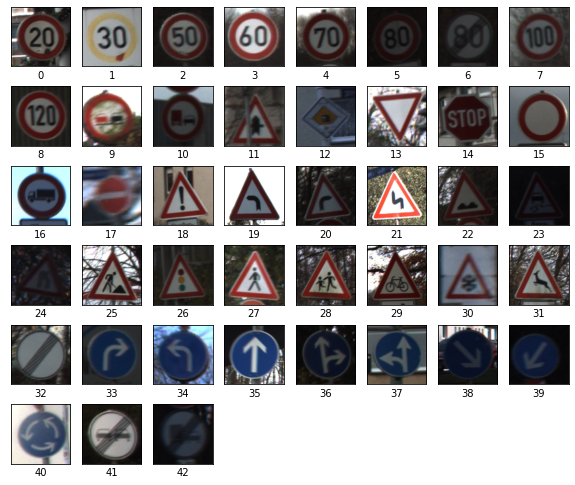

In [17]:
plt.figure(figsize=(10,10))
for i in range(43):
    
    for x in range(len(subset)):
        if labels_num[x][0] == i:
            select = x
    
    plt.subplot(7,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[select,0], cmap=plt.cm.binary)
    plt.xlabel(labels_list[select])

In [18]:
x_train, x_val, y_train, y_val = train_test_split(data, labels_list, test_size = 0.2, random_state = 50)

### Usng data generators

In [2]:
train_dir = '../content/Data - Copy/archive/Train'

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen_preprocessing = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False, 
    vertical_flip = False,
    preprocessing_function=preprocess_input, 
    validation_split = 0.2)

train_generator_preprocessing = train_datagen_preprocessing.flow_from_directory(
    train_dir,
    classes = classes,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical', 
    subset = 'training')

val_generator_preprocessing = train_datagen_preprocessing.flow_from_directory(
    train_dir,
    classes = classes,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical', 
    subset = 'validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [82]:

## Unsure of the effects of preprocessing on this dataset so will have two sets, one with and one without

train_datagen_no_preprocessing = ImageDataGenerator(
   
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False, 
    vertical_flip = False, 
    validation_split = 0.2)

train_generator_no_preprocessing = train_datagen_no_preprocessing.flow_from_directory(
    train_dir,
    classes = classes,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical', 
    subset = 'training')

val_generator_no_preprocessing = train_datagen_no_preprocessing.flow_from_directory(
    train_dir,
    classes = classes,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical', 
    subset = 'validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [110]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_model_trained = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model_trained.trainable = False ## Not trainable weights
base_model_scratch =  VGG16(weights= None, include_top=False, input_shape=(150, 150, 3))
base_model_scratch.trainable = True ##trainable weights

In [84]:
base_model_trained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [111]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(43, activation='softmax')

## model 1 is using the pre trained network
#model_1 = models.Sequential([
#    base_model_trained,
#    flatten_layer,
#    dense_layer_1,
#    dense_layer_2,
#    prediction_layer
#])

## model 2 is using the network with no loaded weighted
model_2 = models.Sequential([
    base_model_scratch,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [112]:
from tensorflow.keras.callbacks import EarlyStopping

#model_1.compile(
#    optimizer='adam',
#    loss='categorical_crossentropy',
#    metrics=['accuracy'],
#)

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [87]:
## Run 1, using the pretrained model on the preprocessed input

history_1 = model_1.fit_generator(
    train_generator_preprocessing,
    steps_per_epoch= (train_generator_preprocessing.samples/32),
    epochs=30, 
    validation_data= val_generator_preprocessing,
    callbacks=[es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
980/980 [==============================] - 223s 226ms/step - loss: 1.5842 - accuracy: 0.5578 - val_loss: 1.3605 - val_accuracy: 0.5861
Epoch 2/30
980/980 [==============================] - 220s 224ms/step - loss: 0.7121 - accuracy: 0.7862 - val_loss: 1.1150 - val_accuracy: 0.6717
Epoch 3/30
980/980 [==============================] - 221s 226ms/step - loss: 0.4998 - accuracy: 0.8479 - val_loss: 1.1644 - val_accuracy: 0.6824
Epoch 4/30
980/980 [==============================] - 224s 229ms/step - loss: 0.4066 - accuracy: 0.8739 - val_loss: 1.1376 - val_accuracy: 0.6923
Epoch 5/30
980/980 [==============================] - 224s 228ms/step - loss: 0.3442 - accuracy: 0.8910 - val_loss: 1.2187 - val_accuracy: 0.6953
Epoch 6/30
980/980 [==============================] - 226s 231ms/step - loss: 0.2972 - accuracy: 0.9064 - val_loss: 1.2991 - val_accuracy: 0.6902
Epoch 7/30
980/980 [==============================] - 226s 231ms/step - loss: 0.2712 - accuracy: 0.9113 - val_loss: 1.3172 -

In [113]:
## Run 2, using the untrained model on the preprocessed input

history_2 = model_2.fit_generator(
    train_generator_preprocessing,
    steps_per_epoch= (train_generator_preprocessing.samples/32),
    epochs=30, 
    validation_data= val_generator_preprocessing,
    callbacks=[es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
980/980 [==============================] - 261s 265ms/step - loss: 3.6424 - accuracy: 0.0564 - val_loss: 3.4878 - val_accuracy: 0.0566
Epoch 2/30
980/980 [==============================] - 256s 261ms/step - loss: 3.4922 - accuracy: 0.0550 - val_loss: 3.4890 - val_accuracy: 0.0566
Epoch 3/30
980/980 [==============================] - 255s 260ms/step - loss: 3.4902 - accuracy: 0.0559 - val_loss: 3.4895 - val_accuracy: 0.0528
Epoch 4/30
980/980 [==============================] - 254s 259ms/step - loss: 3.4896 - accuracy: 0.0554 - val_loss: 3.4886 - val_accuracy: 0.0566
Epoch 5/30
980/980 [==============================] - 254s 259ms/step - loss: 3.4896 - accuracy: 0.0556 - val_loss: 3.4901 - val_accuracy: 0.0474
Epoch 6/30
980/980 [==============================] - 255s 260ms/step - loss: 3.4893 - accuracy: 0.0548 - val_loss: 3.4880 - val_accuracy: 0.0574
Epoch 7/30
980/980 [==============================] - 256s 261ms/step - loss: 3.4891 - accuracy: 0.0546 - val_loss: 3.4888 -

In [107]:
def plots2(history):
    history_dict = history.history
    history_dict.keys()
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = history.epoch
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

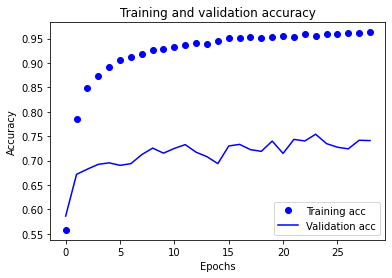

In [108]:
plots2(history_1)

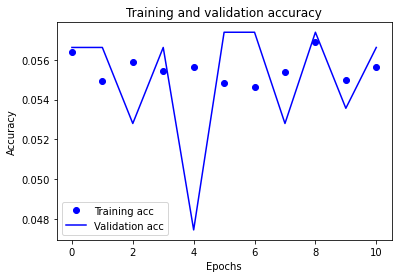

In [114]:
plots2(history_2)

### Evalulating on the test set - with preprocessing

In [93]:
from math import ceil
image_path = '../content/Data - Copy/archive'

data= pd.read_csv("../content/Data - Copy/archive/Test.csv")

pred_labels = np.array(data["ClassId"]) # list of image names

pred_labels_batch = []

for i in range(0, ceil(12630/32)):
  pred_labels_batch.append(to_categorical([pred_labels[(32*i):((i+1)*32)]], num_classes = 43))


pred_datagen = ImageDataGenerator(rescale=1./255, 
                                  preprocessing_function=preprocess_input)

pred_generator = pred_datagen.flow_from_directory(image_path,
                              # only read images from `test` directory
                              classes=['Test'],
                              # don't generate labels
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              batch_size = 12630,
                              # use same size as in training
                              target_size=(150, 150))
#x = next(pred_generator)

Found 12630 images belonging to 1 classes.


In [116]:
x = 0

In [97]:
pred_generator.reset()
x = next(pred_generator)
score_1 = model_1.evaluate(x, to_categorical(pred_labels, num_classes = 43))

395/395 [==============================] - 17s 42ms/step - loss: 1.3887 - accuracy: 0.7727


In [115]:
pred_generator.reset()
x = next(pred_generator)
score_2 = model_2.evaluate(x, to_categorical(pred_labels, num_classes = 43))

395/395 [==============================] - 15s 37ms/step - loss: 3.4640 - accuracy: 0.0594


### Need to start over so we can run with the images with no preprocessing

In [9]:
## model 3 is using the pre trained network
model_3 = models.Sequential([
    base_model_trained,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

## model 4 is using the network with no loaded weighted
model_4 = models.Sequential([
    base_model_scratch,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

from tensorflow.keras.callbacks import EarlyStopping

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [10]:
## Run 3, using the pretrained model on the input with no preprocessing

history_3 = model_3.fit_generator(
    train_generator_no_preprocessing,
    steps_per_epoch= (train_generator_no_preprocessing.samples/32),
    epochs=30, 
    validation_data= val_generator_no_preprocessing,
    callbacks=[es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
980/980 [==============================] - 258s 253ms/step - loss: 1.4686 - accuracy: 0.5866 - val_loss: 1.2001 - val_accuracy: 0.6375
Epoch 2/30
980/980 [==============================] - 227s 231ms/step - loss: 0.6470 - accuracy: 0.8039 - val_loss: 1.1701 - val_accuracy: 0.6776
Epoch 3/30
980/980 [==============================] - 227s 232ms/step - loss: 0.4570 - accuracy: 0.8584 - val_loss: 1.0655 - val_accuracy: 0.6986
Epoch 4/30
980/980 [==============================] - 228s 232ms/step - loss: 0.3651 - accuracy: 0.8864 - val_loss: 1.1877 - val_accuracy: 0.6963
Epoch 5/30
980/980 [==============================] - 229s 233ms/step - loss: 0.3062 - accuracy: 0.9014 - val_loss: 1.1063 - val_accuracy: 0.7202
Epoch 6/30
980/980 [==============================] - 228s 233ms/step - loss: 0.2640 - accuracy: 0.9149 - val_loss: 1.1556 - val_accuracy: 0.7185
Epoch 7/30
980/980 [==============================] - 226s 231ms/step - loss: 0.2383 - accuracy: 0.9208 - val_loss: 1.0944 -

In [ ]:
## Run 4, using the untrained model on the input with no preprocessing

history_3 = model_4.fit_generator(
    train_generator_no_preprocessing,
    steps_per_epoch= (train_generator_no_preprocessing.samples/32),
    epochs=30, 
    validation_data= val_generator_no_preprocessing,
    callbacks=[es])

Evaluating on test set - with no preprocessing

In [42]:
pred_datagen_no_preprocessing = ImageDataGenerator(rescale=1./255)

pred_generator_no_preprocessing = pred_datagen_no_preprocessing.flow_from_directory(image_path,
                              # only read images from `test` directory
                              classes=['Test'],
                              # don't generate labels
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              batch_size = 1000,
                              # use same size as in training
                              target_size=(150, 150))



Found 12630 images belonging to 1 classes.


In [45]:
pred_generator_no_preprocessing.reset()
x = next(pred_generator_no_preprocessing)

i,j = next(val_generator_no_preprocessing)
#score_3 = model_3.evaluate(x, to_categorical(pred_labels[0:1000], num_classes = 43))
score_3 = model_3.evaluate(i,j)

1/1 [==============================] - 0s 75ms/step - loss: 0.6030 - accuracy: 0.8750


In [ ]:
score_4 = model_4.evaluate(x, to_categorical(pred_labels, num_classes = 43))

16
Test/00000.png


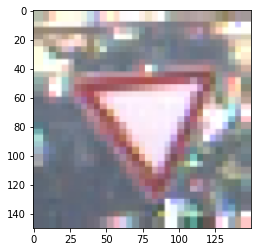

In [46]:
 plt.imshow(x[0], cmap=plt.cm.binary)
 print(pred_labels[0])
 print(pred_generator_no_preprocessing.filenames[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


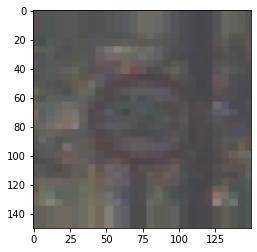

In [75]:
 val_generator_no_preprocessing.reset()
 i,j = next(val_generator_no_preprocessing)
 plt.imshow(i[0], cmap=plt.cm.binary)
 print(j[0])


In [76]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
          preds_cls_idx = label_list.argmax(axis=-1)
          ax.set_title(preds_cls_idx[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

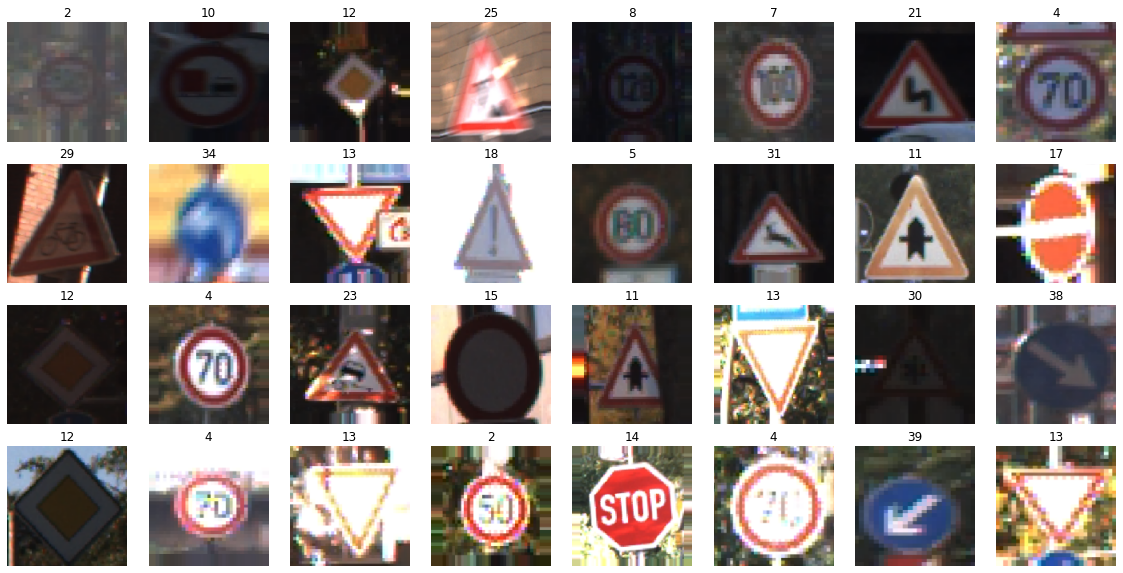

In [77]:

show_grid(i,4,8,label_list=j,show_labels=True,figsize=(20,10))


In [42]:
val_generator.reset()
x_val, y_val = next(val_generator)
#y = to_categorical(pred_labels[0:32], num_classes = 43)
y.shape

(32, 43)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

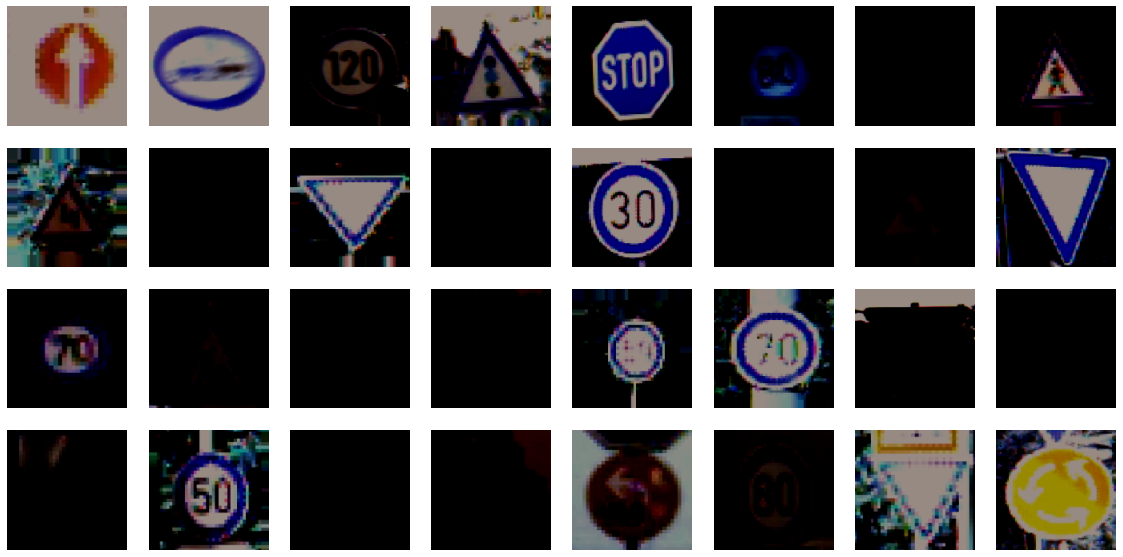

In [20]:
show_grid(x_val,4,8,label_list=y_val,show_labels=False,figsize=(20,10))

In [40]:
preds_cls_idx = pred.argmax(axis=-1)